In [1]:
import planetary_computer
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Access the NSRDB dataset on Azure and connect to the 2022 file
fs = planetary_computer.get_adlfs_filesystem('nrel', 'nrel-nsrdb')
file = fs.open('nrel-nsrdb/current/nsrdb_2022.h5')
ds = xr.open_dataset(file, backend_kwargs={"phony_dims": "sort"}, engine="h5netcdf")
ds

<xarray.Dataset> Size: 7TB
Dimensions:                   (phony_dim_0: 17520, phony_dim_1: 2018267)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables: (12/28)
    air_temperature           (phony_dim_0, phony_dim_1) float64 283GB ...
    alpha                     (phony_dim_0, phony_dim_1) float64 283GB ...
    aod                       (phony_dim_0, phony_dim_1) float64 283GB ...
    asymmetry                 (phony_dim_0, phony_dim_1) float64 283GB ...
    cld_opd_dcomp             (phony_dim_0, phony_dim_1) float64 283GB ...
    cld_press_acha            (phony_dim_0, phony_dim_1) float64 283GB ...
    ...                        ...
    surface_albedo            (phony_dim_0, phony_dim_1) float64 283GB ...
    surface_pressure          (phony_dim_0, phony_dim_1) float64 283GB ...
    time_index                (phony_dim_0) |S25 438kB ...
    total_precipitable_water  (phony_dim_0, phony_dim_1) float64 283GB ...
    wind_direction            (phony_dim_0, phony_dim_1) float64 283GB ...
    wind_speed                (phony_dim_0, phony_dim_1) float64 283GB ...
Attributes:
    full_version_record:  {"rex": "0.2.80", "pandas": "2.0.0", "numpy": "1.23...
    package:              rex
    version:              4.0.0

Text(0.5, 1.0, 'Colorado Air Temperature at 2022-01-01 00:00:00+00:00')

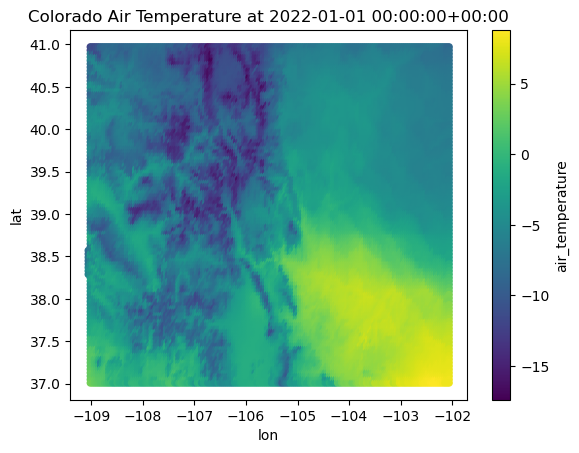

In [3]:
# Pick a time_index and get its datetime
timestep = 0
time_str = ds['time_index'][timestep].values.item().decode()

# Capture metadata in a pandas dataframe
meta = pd.DataFrame(ds['meta'].values) 

# Find the positions where df['state'] is Colorado
CO = meta[meta["state"] == b"Colorado"]

# load a subset of that data
subset = ds["air_temperature"][timestep, CO.index].load()

# Apply scale factor
sf = ds['air_temperature'].attrs['psm_scale_factor']
subset /= sf ** 2   # xarray multiplies values by the scale factor, which is incorrect, so we need to back that out and then apply it

# Store in dataframe
data = pd.DataFrame({"air_temperature": subset, "lat": CO.latitude, "lon": CO.longitude})

# Plot data
data.plot.scatter(x="lon", y="lat", c="air_temperature", cmap="viridis")
plt.title(f'Colorado Air Temperature at {time_str}')